# Regression - More or Fewer Cameras

In [7]:
import pandas as pd
from pandas.api.types import CategoricalDtype
from statsmodels.miscmodels.ordinal_model import OrderedModel
import preprocessing

In [8]:
df = preprocessing.preprocessed_data('FinalResults.csv')

In [9]:
from pandas.api.types import CategoricalDtype

ordered_q4 = CategoricalDtype(categories=[
    'Significantly fewer',
    'Somewhat fewer',
    'About the same',
    'Not sure',
    'Somewhat more',
    'Significantly more'
], ordered=True)

df['Q4'] = df['Q4_Do you think there should be more or fewer CCTV surveillance cameras in the city centre of Groningen?'].astype(ordered_q4)


In [10]:
# Likert-style mapping for Q3, Q6, Q7
likert_map = {
    'No, definitely not': 0,
    'Probably not': 1,
    'I don’t know': 2,
    'Probably': 3,
    'Yes, definitely': 4
}

df['Q3'] = df['Q3_Do you think the municipality should use AI with its CCTV surveillance system?'].map(likert_map)
df['Q6'] = df['Q6_Do you think CCTV surveillance cameras help improve safety in the city centre?'].map(likert_map)
df['Q7'] = df['Q7_Do you feel safer knowing there are CCTV surveillance cameras installed when traveling outside?'].map(likert_map)

In [11]:
# Privacy concern: Q5 – Ordered mapping
privacy_map = {
    'Not concerned at all': 0,
    'Slightly concerned': 1,
    'Moderately concerned': 2,
    'Very concerned': 3,
    'Extremely concerned': 4
}

df['Q5'] = df['Q5_To what extent are you concerned about privacy related to CCTV surveillance cameras in Groningen?'].map(privacy_map)

In [12]:
df_model = df[['Q1_How many CCTV cameras for surveillance do you think the municipality of Groningen currently owns?',
               #'Q10_Which political party do you most align with? (Optional)',
               'Q3', 'Q5', 'Q6', 'Q7', 'Q4']].copy()

# Rename for convenience
df_model.columns = ['Q1', 
                    # 'Q10', 
                    'Q3', 'Q5', 'Q6', 'Q7', 'Q4']

# Drop rows with missing values
df_model = df_model.dropna()


# df_model = pd.get_dummies(df_model, columns=['Q10'], drop_first=True)

In [13]:
X = df_model.drop(columns='Q4').astype('float64')
y = df_model['Q4']

model = OrderedModel(y, X, distr='logit')
res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.467713
         Iterations: 32
         Function evaluations: 38
         Gradient evaluations: 38
                             OrderedModel Results                             
Dep. Variable:                     Q4   Log-Likelihood:                -334.64
Model:                   OrderedModel   AIC:                             689.3
Method:            Maximum Likelihood   BIC:                             723.6
Date:                Tue, 06 May 2025                                         
Time:                        15:55:29                                         
No. Observations:                 228                                         
Df Residuals:                     218                                         
Df Model:                           5                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------

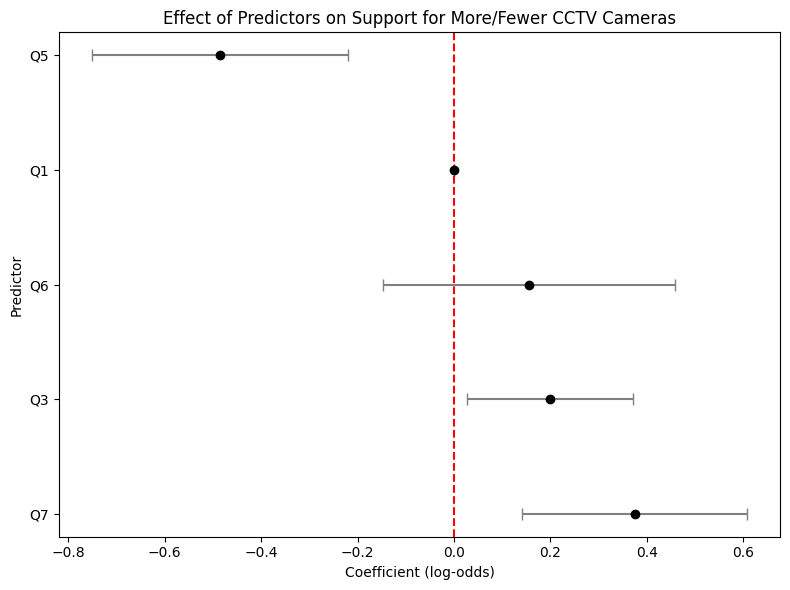

In [15]:
import matplotlib.pyplot as plt

# Extract coefficients and confidence intervals
params = res.params
conf = res.conf_int()
conf.columns = ['Lower', 'Upper']

# Only include predictor coefficients (exclude thresholds)
predictors = params.index[:len(X.columns)]
coef_df = pd.DataFrame({
    'Coefficient': params[predictors],
    'Lower CI': conf.loc[predictors, 'Lower'],
    'Upper CI': conf.loc[predictors, 'Upper']
}).sort_values(by='Coefficient', ascending=False)

# Plot
plt.figure(figsize=(8, 6))
plt.errorbar(coef_df['Coefficient'], coef_df.index, 
             xerr=[coef_df['Coefficient'] - coef_df['Lower CI'], 
                   coef_df['Upper CI'] - coef_df['Coefficient']],
             fmt='o', color='black', ecolor='gray', capsize=4)

plt.axvline(0, color='red', linestyle='--')
plt.title('Effect of Predictors on Support for More/Fewer CCTV Cameras')
plt.xlabel('Coefficient (log-odds)')
plt.ylabel('Predictor')
plt.tight_layout()
plt.show()


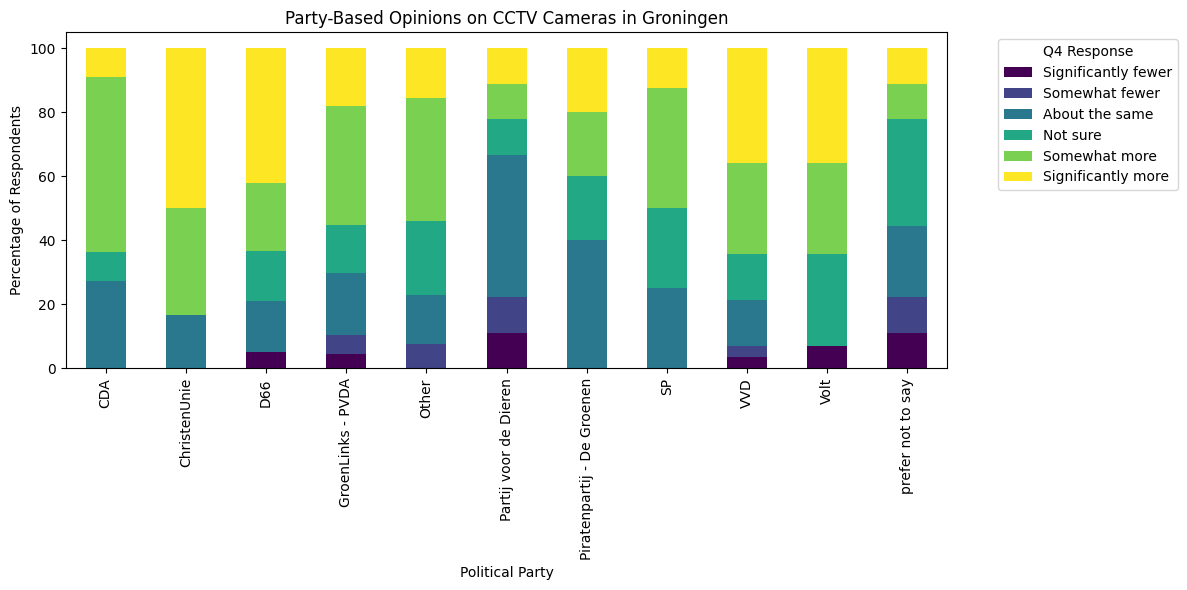

In [14]:
# Visualisation: Party-Based Opinion Shifts on Q4
import seaborn as sns
import matplotlib.pyplot as plt

# Work from original df (not one-hot encoded)
viz_df = df[['Q10_Which political party do you most align with? (Optional)',
             'Q4_Do you think there should be more or fewer CCTV surveillance cameras in the city centre of Groningen?']].dropna()

# Rename for convenience
viz_df = viz_df.rename(columns={
    'Q10_Which political party do you most align with? (Optional)': 'Party',
    'Q4_Do you think there should be more or fewer CCTV surveillance cameras in the city centre of Groningen?': 'Q4'
})

# Optional: Group rare parties
party_counts = viz_df['Party'].value_counts()
rare_parties = party_counts[party_counts < 5].index  # adjust threshold if needed
viz_df['Party'] = viz_df['Party'].replace(rare_parties, 'Other')

# Set category order for Q4
ordered_q4 = [
    'Significantly fewer',
    'Somewhat fewer',
    'About the same',
    'Not sure',
    'Somewhat more',
    'Significantly more'
]
viz_df['Q4'] = pd.Categorical(viz_df['Q4'], categories=ordered_q4, ordered=True)

# Create normalized count data
count_data = pd.crosstab(viz_df['Party'], viz_df['Q4'], normalize='index') * 100
count_data = count_data[ordered_q4]  # Ensure correct order

# Plot: Proportional Stacked Bar Chart
count_data.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))

plt.title("Party-Based Opinions on CCTV Cameras in Groningen")
plt.xlabel("Political Party")
plt.ylabel("Percentage of Respondents")
plt.legend(title="Q4 Response", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
